This notebook is not necessarily important because of the sea-ice field. It's just important because I figured out a fix for the issue of getting wacky contour fitting on stereo polar projecteed data. Literally danced when I figured it out.

In [1]:
import xarray as xr
import dask.array
import numpy as np
import pandas as pd
import os
import scipy.io
import warnings
warnings.filterwarnings('ignore')
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
import sys
sys.path.append('/home/Ruth.Moorman/OM4p25_JRA55-do_simulations')
### import required python functions
# from om4_tools import *
# from ssh_contours import *
## plotting
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.cm as pcm
import cartopy.crs as ccrs
import cartopy.feature
import matplotlib.path as mpath
import matplotlib.ticker as mticker
import matplotlib.colors as col
import cmocean.cm as cm
from matplotlib import rc, rcParams
rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
import sys
sys.path.append('/home/Ruth.Moorman/')
import nclcmaps
import cv2
rcParams["contour.negative_linestyle"] = 'solid'
rc('xtick', labelsize=30) 
rc('ytick', labelsize=30) 
rc('axes', labelsize=30)

In [2]:
# start with mapping the bathymetry
# only interested in the Southern Ocean south of 29S generally
expdir = '/archive/Ruth.Moorman/OM4p25_IAF_BLING_CFC_csf_JRA55do1-3_r4r/'
static = xr.open_dataset(expdir+'/cycle1/ocean_static/20170101.ocean_static.nc')
lat_north = -29
bathy = static.deptho.sel(yh = slice(-90,lat_north))
land_mask = static.wet.sel(yh = slice(-90,lat_north))
geolon = static.geolon.sel(yh = slice(-90,lat_north))
geolat = static.geolat.sel(yh = slice(-90,lat_north))

In [3]:
## load the ssh product
A18_ssh = xr.open_dataset('/work/Ruth.Moorman/CS2_combined_Southern_Ocean_2011-2016.nc')

In [4]:
def so_basics(ax,land_mask,geolon, geolat, lat_north = -29, grid = True):
    latslice = slice(-90,lat_north)
    ax.contour(geolon.sel(yh = latslice), geolat.sel(yh = latslice),land_mask.sel(yh = latslice),[0,1], colors = 'k', alpha = 1, transform=ccrs.PlateCarree())
    ax.set_extent([-180, 180, -90, lat_north], ccrs.PlateCarree())
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    if grid == True:
        gl = ax.gridlines(linewidth = 1, color = 'grey', linestyle = '--', alpha = 0.7)
        gl.ylocator = mticker.FixedLocator([-90,-80,-70, -60, -50, -40, -30])

In [5]:
DOT = A18_ssh.DOT
SLA = A18_ssh.SLA
MDT = A18_ssh.MDT

In [6]:
longitude = A18_ssh.Longitude
latitude = A18_ssh.Latitude


## this is a common issue I come across

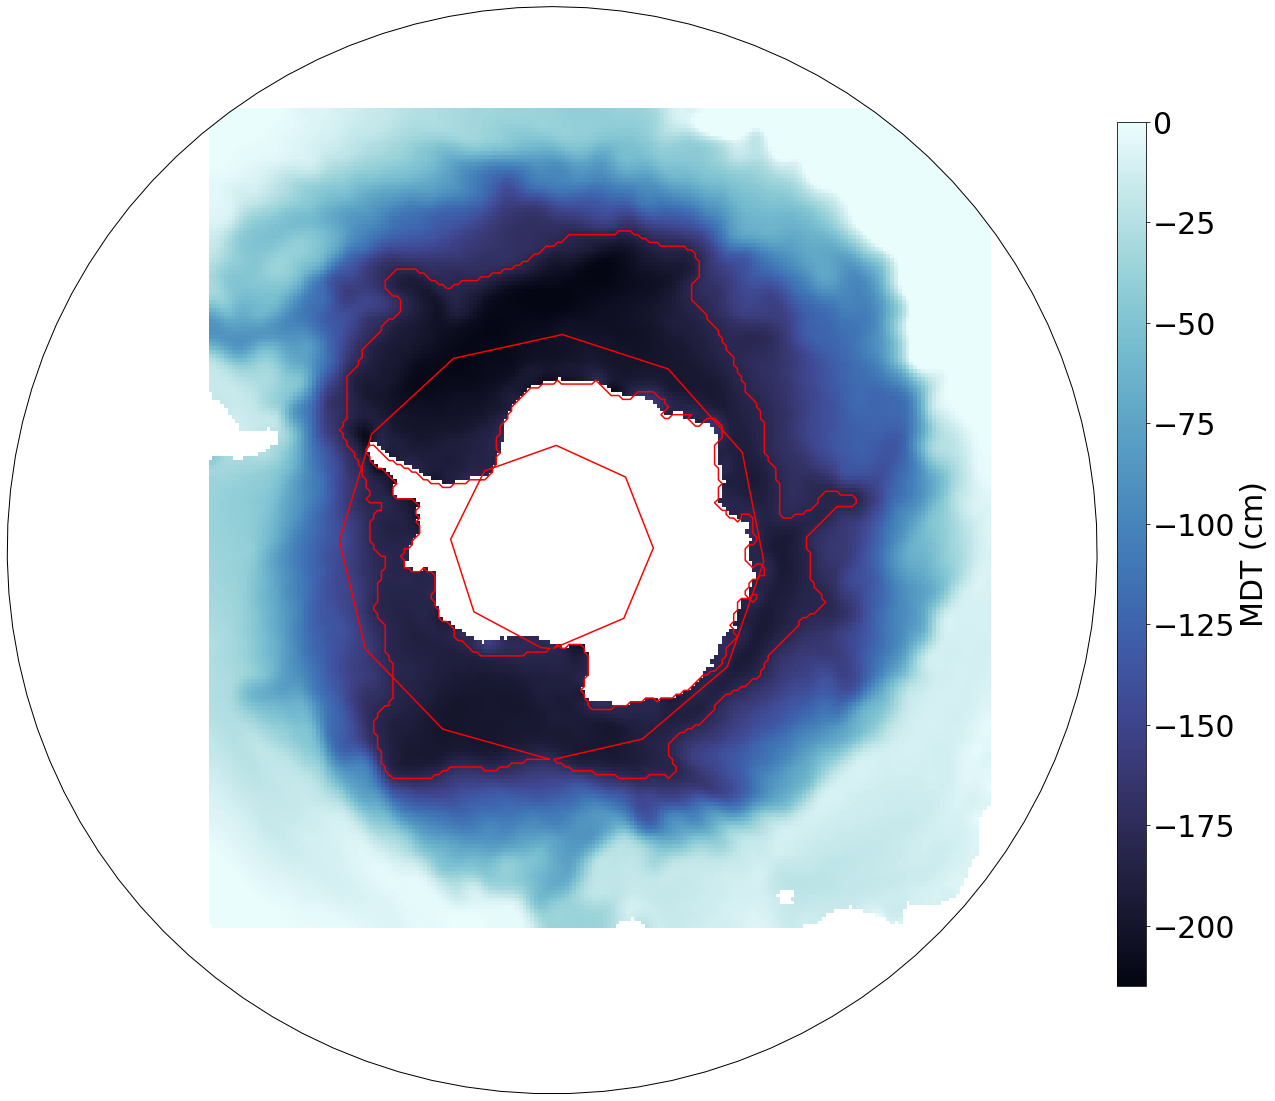

In [7]:
fig = plt.figure(figsize=[20, 20])
proj = ccrs.Stereographic(central_longitude=0,central_latitude=-90)
ax = plt.subplot(projection = proj)
lat_north = -30
ax.set_extent([-180, 180, -90, lat_north], ccrs.PlateCarree())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

norm = col.Normalize(vmin=-215,vmax=0) 
cf = ax.pcolormesh(A18_ssh.Longitude, A18_ssh.Latitude, A18_ssh.MDT, norm = norm, cmap = cm.ice, transform = ccrs.PlateCarree())
contour = (A18_ssh.MDT.where(A18_ssh.MDT<-180)*0+1).fillna(0)

ax.contour(longitude,latitude, contour, levels = [0,1], colors = 'r', transform = ccrs.PlateCarree())
# ax.contour(longitude.sortby(longitude[0,:]),latitude.sortby(longitude[0,:]), contour.sortby(longitude[0,:]), levels = [0,1], colors = 'r', transform = ccrs.PlateCarree())

cax = fig.add_axes([0.905, 0.2, 0.02, 0.6])
cbar=plt.colorbar(cf,cax = cax,orientation='vertical',shrink = 0.5)
cax.set_ylabel('MDT (cm)', fontsize = 30)

plt.show()

## solution is sorting by longitude

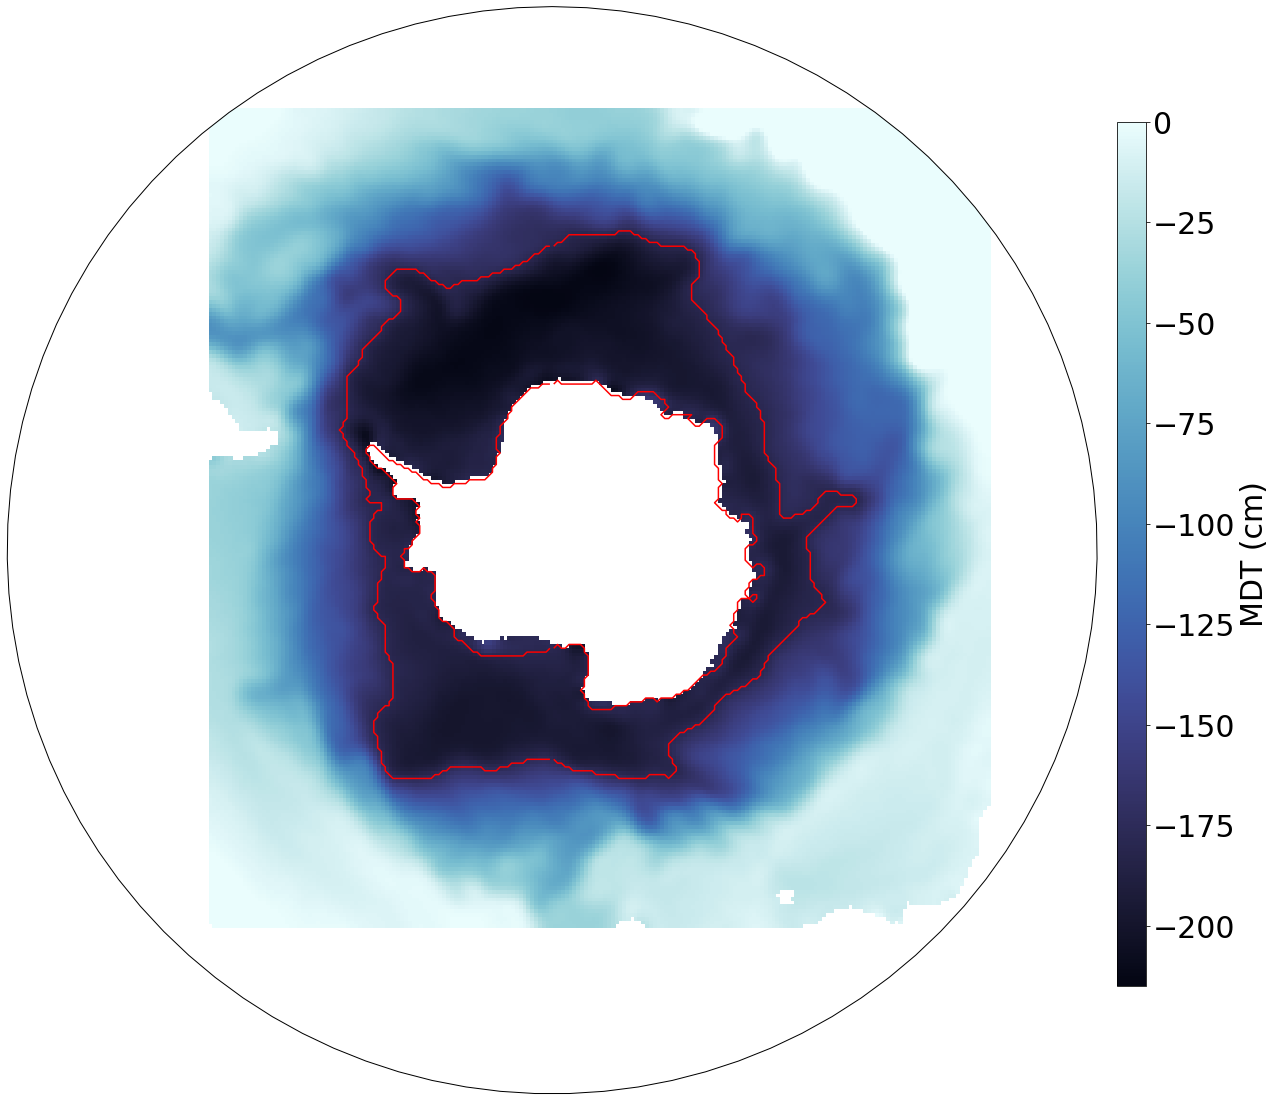

In [8]:
fig = plt.figure(figsize=[20, 20])
proj = ccrs.Stereographic(central_longitude=0,central_latitude=-90)
ax = plt.subplot(projection = proj)
lat_north = -30
ax.set_extent([-180, 180, -90, lat_north], ccrs.PlateCarree())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

norm = col.Normalize(vmin=-215,vmax=0) 
cf = ax.pcolormesh(A18_ssh.Longitude, A18_ssh.Latitude, A18_ssh.MDT, norm = norm, cmap = cm.ice, transform = ccrs.PlateCarree())
contour = (A18_ssh.MDT.where(A18_ssh.MDT<-180)*0+1).fillna(0)

# ax.contour(longitude,latitude, contour, levels = [0,1], colors = 'r', transform = ccrs.PlateCarree())
ax.contour(longitude.sortby(longitude[0,:]),latitude.sortby(longitude[0,:]), contour.sortby(longitude[0,:]), levels = [0,1], colors = 'r', transform = ccrs.PlateCarree())

cax = fig.add_axes([0.905, 0.2, 0.02, 0.6])
cbar=plt.colorbar(cf,cax = cax,orientation='vertical',shrink = 0.5)
cax.set_ylabel('MDT (cm)', fontsize = 30)

plt.show()